In [1]:
####This cell was added by kaggle themselves.

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple390.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple2253.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple2203.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple2922.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple3413.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple1355.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple3088.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple125.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple2452.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple101.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple455.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask/simple/simple3568.jpg
/kaggle/input/face-mask-dataset/FMD_DATASET/without_mask

In [2]:
#Here we import all necessary libraries
import os
import pandas as pd
import numpy as np
import itertools

#RANDOM SEED FOR REPRODDUCABILITY 
np.random.seed(2)

#...Related to tensor flow and Keras.
import tensorflow as tf #In order to import Keras
from tensorflow import keras #Keras is an API for neural networks


from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers.preprocessing.image_preprocessing import (RandomContrast, RandomRotation,
RandomFlip) #These augment our training data


from keras.models import Sequential #To build a model
from keras.layers import (Conv2D, Dropout, MaxPool2D, BatchNormalization, 
Dense, Flatten, Rescaling) #These layers are used to go over the images


#Matplot basics :) These will help us visualise the images in data,
#and also the loss & accuracy metrics.
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large', titleweight='bold', titlesize = 10,
    titlepad = 10)
plt.rc('image', cmap = 'magma')

In [3]:
#IMPORTING DATASET
##Adapted to kaggle, so I am leaving this bit as a comment.

#Kaggle things for the dataset..
#!pip install kaggle #Installed the Kaggle API
#There has to be authentication to access these datasets.
#Provided API Token allows access Kaggle datasets. 
#from google.colab import files

#Now importing the dataset!
#!kaggle datasets download -d shiekhburhan/face-mask-dataset 

#print('The dataset is downloaded from Kaggle!')


#The dataset is downloaded as a zip file.
#In order to use the images and labels, we extract the file.
#from zipfile import ZipFile
#dataset_source = "/content/face-mask-dataset.zip" 
#with ZipFile(dataset_source, 'r') as zip:
#  zip.extractall()

#print('The zip file is extracted.')





In [4]:
from keras_preprocessing.image.affine_transformations import random_rotation
print('This cell will generate training and validation sets from our dataset.')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #In order to avoid future problems...
#Sometimes images in the database are truncated, which can annoy the model..
#This still loads the truncated images, but the model doesnt complain :p

datagen = ImageDataGenerator(rescale = 1/255, validation_split=0.2,
                             rotation_range=30,
                             vertical_flip = True, horizontal_flip=True,) 
#While loading the images from the dataset, 'datagen' will apply random transformations
#To the training data. This allows the model to train with a rich 
#Training dataset, with images showing objects in different situations.
#This way, the model is prepared for 'unusual' test images!

####


#Generating the datasets:

ds_train = datagen.flow_from_directory('../input/face-mask-dataset/FMD_DATASET', target_size = (128,128), batch_size=64,
                                       class_mode = 'categorical', subset = 'training', shuffle = True, color_mode = 'rgb')

ds_val = datagen.flow_from_directory('../input/face-mask-dataset/FMD_DATASET', target_size = (128, 128), batch_size=64,
                                       class_mode = 'categorical', subset = 'validation', shuffle = False, color_mode = 'rgb')

print(ds_train.class_indices) #Names of our 3 image classes!
#The labels are inferred from the file names in the directory.


This cell will generate training and validation sets from our dataset.
Found 11630 images belonging to 3 classes.
Found 2906 images belonging to 3 classes.
{'incorrect_mask': 0, 'with_mask': 1, 'without_mask': 2}


**2. Feature Engineering!**

/ Here we adjust the dataset so that the images are adapted to the model we will use. But first, lets examine our images.

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


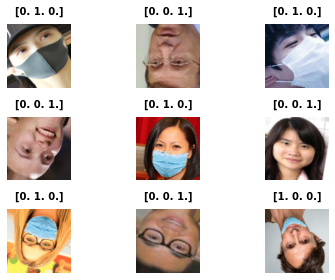

In [5]:
image_batch, labels_batch = ds_train.next()

for i in range(9):
  ax = plt.subplot(3, 3, i + 1) #Generating a 3x3 plot to visualise 9 images from each batch.
  plt.imshow(image_batch[i]) 
  plt.title(labels_batch[i])
  plt.axis("off")
#Note:
#[1.0.0.] = 'incorrect_mask
#[0.1.0.] = 'with_mask'
#[0.0.1.] = 'without_mask'

In [6]:
#Everything seems normal! Now we can check the shape of the images.
#Checks what one batch from the training dataset looks like.
for image_batch, labels_batch in ds_train:
  print(image_batch.shape) #Should be batch size 64, image sizes 128 x128,channel number 3 (rgb)
  print(labels_batch.shape) #Should be 64, 3 
  break

#This shape is the input shape of the model that will be constructed later.
input_shape = ds_train.image_shape #Storing it into a variable so it can be used in model.
print(input_shape)

(64, 128, 128, 3)
(64, 3)
(128, 128, 3)


In [7]:
#OneHotEncoding.
#Appearenly Keras mdoels aren't great with categorical variables ...
from numpy import asarray
from sklearn.preprocessing import OneHotEncoder
# define which labels to transform
data = asarray([['incorrect_mask'], ['with_mask'], ['without_mask']])
print(data)
# define one hot encoding
encoder = OneHotEncoder(sparse=False)
# transform labels 
onehot = encoder.fit_transform(data)
print(onehot)



[['incorrect_mask']
 ['with_mask']
 ['without_mask']]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


3. **Building the model**

In [8]:
from tensorflow.keras import layers, callbacks

#This callback option allows the model to keep the optimal weights.
early_stopping = callbacks.EarlyStopping(
    min_delta=0.002, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True )#This allows the model to keep the best weights and minimizes the chances of overfitting

In [9]:
#Time to build the convolutional neural network


from warnings import filters
#We will build a CNN model using Keras layers. 
mask_model = Sequential([
                         

  #Convolution layers extract features from the image.
  #Pooling layers allow detecting  features no matter where they are
  #located on the image.
  
  keras.layers.Conv2D(input_shape = input_shape, filters = 64,  #The input shape is 256x256 pixels with 3 color channels of RGB.
                      kernel_size = 3, activation = 'relu', 
                      padding = 'same'),
  keras.layers.MaxPool2D(),
  keras.layers.BatchNormalization(),  #Normalize the batch before going deeper
  keras.layers.Dropout(rate= 0.25),
  keras.layers.Conv2D(filters = 64, 
                      kernel_size = [3,3], activation = 'relu', 
                      strides = 2, padding = 'same'),

  keras.layers.Dropout(rate= 0.25),
  keras.layers.Conv2D(filters = 64, 
                      kernel_size = [3,3], activation = 'relu', 
                      strides = 1, padding = 'same'),
  keras.layers.MaxPool2D(),
  


  #Classifying head: These layers classify the image based on
  #Features extracted in previous layers.
  keras.layers.Flatten(), #Our input had 3 dimensions: heightxwidthxchannel number.
  #this layer 'flattens' the information so it is can provide
  #The 1 dimensional label.
  keras.layers.Dense(16, activation = 'relu'),
  keras.layers.Dense(3, activation= 'softmax') 
])


mask_model.summary() #Just to see the characteristics of the layers and
#Their outputs!

#COMPILING THE MODEL USING OPTIMIZERS

from keras.optimizer_v2.gradient_descent import SGD
mask_model.compile(optimizer = 'SGD', metrics = ['categorical_accuracy'],
                   loss = 'categorical_crossentropy')
  #SGD - Stochastic Gradient Descent ! 
  #Accuracy of the model is tracked by categorical accuracy
  #The loss metric directs the model to its goal. In this case,
  #Categorical Crossentropy metric is used.

2022-07-15 18:12:45.312610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 18:12:45.411774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 18:12:45.413150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 18:12:45.415380: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        3

In [10]:
#Now we make the model fit the training data, and
#Use the validation data to test it.
history = mask_model.fit(ds_train, #fit on the training dataset
                         batch_size = 64, 
                         validation_data=ds_val, #Test using the validation dataset
                         epochs = 10, #You can change this to make training longer!
                         verbose = 1, #This shows each epoch progress. You can shut it up by setting to 0.
                         callbacks = early_stopping #Ensures model keeps best weights
                         )

print('Model is trained!')

2022-07-15 18:12:49.170207: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-07-15 18:12:52.409160: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


104/182 [================>.............] - ETA: 1:33 - loss: 0.5742 - categorical_accuracy: 0.7754

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


182/182 [==============================] - 274s 1s/step - loss: 0.4318 - categorical_accuracy: 0.8390 - val_loss: 1.0024 - val_categorical_accuracy: 0.5024
Epoch 2/10
182/182 [==============================] - 190s 1s/step - loss: 0.2118 - categorical_accuracy: 0.9340 - val_loss: 0.7328 - val_categorical_accuracy: 0.7330
Epoch 3/10
182/182 [==============================] - 190s 1s/step - loss: 0.1925 - categorical_accuracy: 0.9414 - val_loss: 0.5964 - val_categorical_accuracy: 0.7756
Epoch 4/10
182/182 [==============================] - 190s 1s/step - loss: 0.1678 - categorical_accuracy: 0.9466 - val_loss: 0.5998 - val_categorical_accuracy: 0.7777
Epoch 5/10
182/182 [==============================] - 190s 1s/step - loss: 0.1578 - categorical_accuracy: 0.9512 - val_loss: 0.5836 - val_categorical_accuracy: 0.7822
Epoch 6/10
182/182 [==============================] - 191s 1s/step - loss: 0.1465 - categorical_accuracy: 0.9563 - val_loss: 0.6120 - val_categorical_accuracy: 0.7698
Epoch 7/1

**5.Evaluating the model**

We want to maximize accuracy and minimize loss! We have to see how the model is with validation data; it should be good at classifying images that it has not seen before. This model has an approximate accuracy of 77% after 10 epochs with validation set, which is alright but leaves room for improvement.

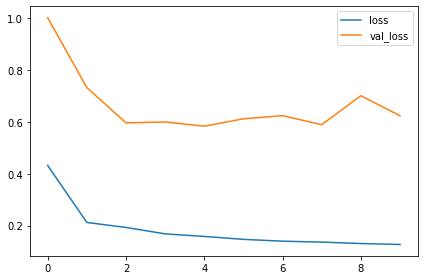

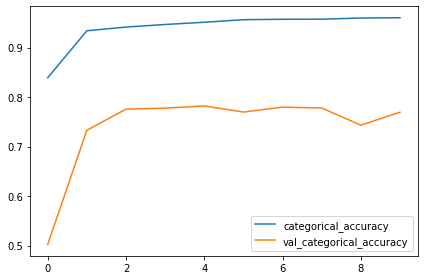

In [11]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

In [12]:
#The training dataset is fairly small and it includes complex images as well. An improved model can be obtained using a pretained model and fitting it into our training data.
#A deeper model had overfitting issues so I had to simplify it. Any suggestions are welcome! :)